In [1]:
import os
import sys
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

import cv2
from PIL import Image as im
from sklearn.metrics import jaccard_score

import collections
from typing import DefaultDict, Tuple, List, Dict
from functools import partial

sys.path.append('early-stopping-pytorch')
from pytorchtools import EarlyStopping

In [2]:
# Retrieve unique ID used to name a model when saving files related to it.
# The current integer is the previously trained model. Training will increment the value.
COUNTER_FILENAME = os.path.expanduser("model_counter.txt")
global MODEL_ID


def update_model_id():
    global MODEL_ID
    with open(COUNTER_FILENAME, "w") as f:
        count = int(MODEL_ID)
        count += 1
        count = str(count)
        f.write(count)
        MODEL_ID = count

        
def retrieve_model_id():
    global MODEL_ID
    try:
        with open(COUNTER_FILENAME, 'r') as f:
            count = f.read()
            MODEL_ID = count
    except FileNotFoundError:
        print('New counter file.')
        with open(COUNTER_FILENAME, 'w') as f:
            count = '0'
            f.write(count)
            MODEL_ID = count

            
retrieve_model_id()

# Adjust printing view dimensions
np.set_printoptions(threshold=sys.maxsize, linewidth=300)
torch.set_printoptions(threshold=sys.maxsize, linewidth=300, profile='full')

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.input_shape = kwargs["input_shape"]
        # number of hidden units in first hidden layer
        self.n_units = kwargs["n_units"]
        # number of hidden units in latent space
        self.latent_units = kwargs["latent_units"]
        
        # ---- ENCODER ---- #
        self.encoder_in = torch.nn.Sequential(
            nn.Linear(
                in_features=self.input_shape, 
                out_features=self.n_units
            ),
            torch.nn.ReLU()
        )
        # Bottleneck is actually in the encoder, but it must be isolated in order to calculate sparsity
        self.bottleneck = torch.nn.Sequential(
            nn.Linear(
                in_features=self.n_units, 
                out_features=self.latent_units
            ),
            torch.nn.ReLU()
        )
        # ----------------- #
        
        # ---- DECODER ---- #
        self.decoder_in = torch.nn.Sequential(
            nn.Linear(
                in_features=self.latent_units, 
                out_features=self.n_units
            ),
            torch.nn.ReLU(),
        )
        # Last layer is separate in order to use a different initialization (on account of sigmoid)
        self.decoder_out = torch.nn.Sequential(
            nn.Linear(
                in_features=self.n_units, 
                out_features=self.input_shape
            ),
            torch.nn.Sigmoid()
        )
        # ----------------- #
    
    # X denotes features
    def forward(self, X):
        encoded = self.encoder_in(X)
        bottleneck = self.bottleneck(encoded)
        decoded = self.decoder_in(bottleneck)
        decoded_out = self.decoder_out(decoded)
        return bottleneck, decoded_out

In [4]:
# Load the dataset
# 10,000 samples, 30x30 matrices
data_count = 10000
data = np.ndarray(shape=(data_count,30,30))
n_features = data.shape[1] * data.shape[2]

for i in range(data_count):
    path = f'data/jet_matrices/sample{i+1}.dat'
    sample = np.loadtxt(path, unpack = False)
    data[i] = sample

print("Done loading data.")


blind = np.ndarray(shape=(3,30,30))
path = 'data/true_diagrams/blind_sample1.dat'
sample = np.loadtxt(path, unpack = False)
blind[0] = sample
path = 'data/true_diagrams/blind_sample2.dat'
sample = np.loadtxt(path, unpack = False)
blind[1] = sample
path = 'data/true_diagrams/blind_sample3.dat'
sample = np.loadtxt(path, unpack = False)
blind[2] = sample

Done loading data.


sample 1113 and blind 3 are equal.


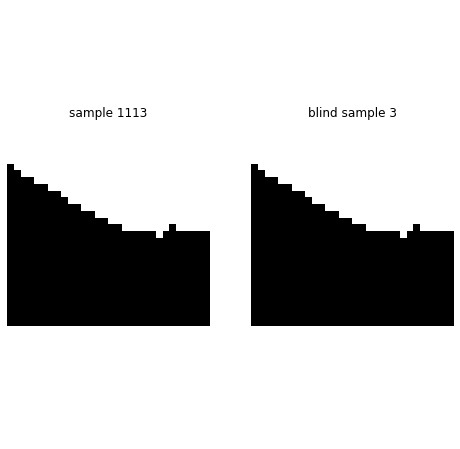

sample 4892 and blind 2 are equal.


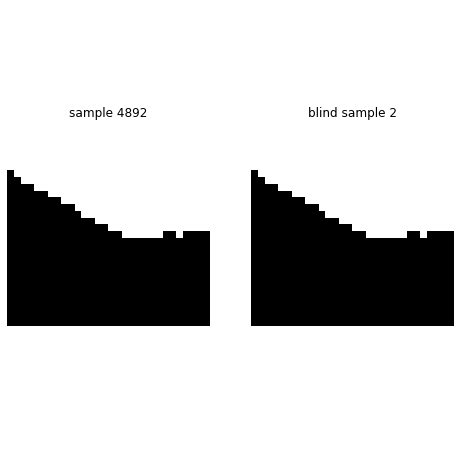

sample 8408 and blind 2 are equal.


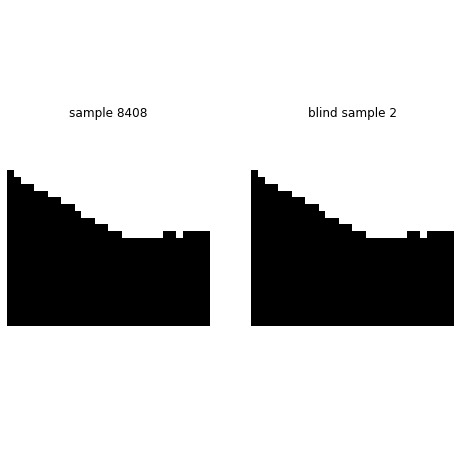

sample 9270 and blind 2 are equal.


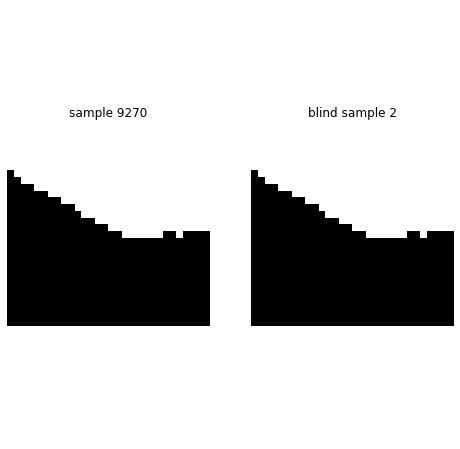

sample 9610 and blind 3 are equal.


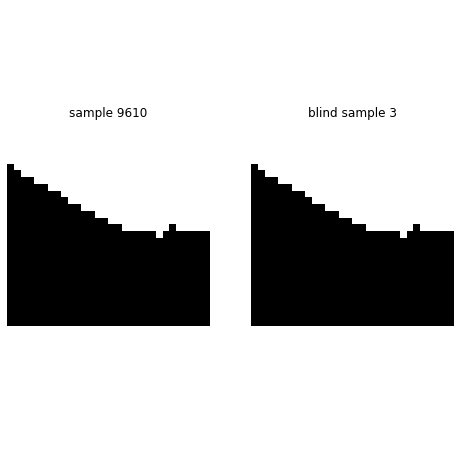

In [39]:
for i, sample in enumerate(data):
    if np.array_equal(sample, blind[0]):
        print(f'sample {i} and blind 1 are equal.')
        fig = plt.figure(figsize=(8, 8))
        plt.axis('off')
        fig.add_subplot(1, 2, 1)
        plt.imshow(sample)
        plt.axis('off')
        title = f'sample {i}'
        plt.title(title)
        plt.gray()

        fig.add_subplot(1, 2, 2)
        plt.imshow(blind[0])
        plt.axis('off')
        plt.title("blind sample 1")
        plt.gray()
        path = f'visualizations/diagrams/sample{i}_blind1.png'
        plt.savefig(path)
        plt.show()
    if np.array_equal(sample, blind[1]):
        print(f'sample {i} and blind 2 are equal.')
        fig = plt.figure(figsize=(8, 8))
        plt.axis('off')
        fig.add_subplot(1, 2, 1)
        plt.imshow(sample)
        plt.axis('off')
        title = f'sample {i}'
        plt.title(title)
        plt.gray()

        fig.add_subplot(1, 2, 2)
        plt.imshow(blind[1])
        plt.axis('off')
        plt.title("blind sample 2")
        plt.gray()
        path = f'visualizations/diagrams/sample{i}_blind2.png'
        plt.savefig(path)
        plt.show()
    if np.array_equal(sample, blind[2]):
        print(f'sample {i} and blind 3 are equal.')
        fig = plt.figure(figsize=(8, 8))
        plt.axis('off')
        fig.add_subplot(1, 2, 1)
        plt.imshow(sample)
        plt.axis('off')
        title = f'sample {i}'
        plt.title(title)
        plt.gray()

        fig.add_subplot(1, 2, 2)
        plt.imshow(blind[2])
        plt.axis('off')
        plt.title("blind sample 3")
        plt.gray()
        path = f'visualizations/diagrams/sample{i}_blind3.png'
        plt.savefig(path)
        plt.show()

In [5]:
# Load parameters corresponding to the 4 variables input into 
# the Helmholtz Resonator function, where output is each sample in dataset.
params = np.ndarray(shape=(data_count,4))

path = r'data/param_lhs.dat'
with open(path) as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        if i >= params.shape[0]:
            break
        param = np.fromstring(line, dtype=float, sep=',')
        params[i] = param

print("Done loading parameters.")

Done loading parameters.


In [6]:
# Flatten data and convert to Torch Tensor

# 10,000 samples, 900 features
X = np.ndarray(shape=(data_count, n_features))
for i, sample in enumerate(data):
    if i >= X.shape[0]:
        break
    flat = sample.flatten()
    X[i] = flat

# Convert from numpy array to Pytorch tensor
X = torch.from_numpy(X)
# Convert all scalars to floats. May affect training behavior (ie. reconstructions made of non-binary scalar values)
X = X.float()

In [7]:
is_pca = False
is_scramble = False

def scramble_data(X):
    print("scrambling data...")
    X_pert = np.copy(X)
    i = 0
    for col in X.T:
        # print(col)
        X_pert[:,i] = np.random.permutation(col)
        # print(X_pert[:,i])
        i += 1
    return X_pert

# Scramble data if using base model
if is_scramble:
    X = scramble_data(X)

# Pair data samples with their corresponding parameter
# in order to keep organized during random splitting.
X_with_params = []
for i in range(data_count):
    pair = [X[i], params[i], i]
    X_with_params.append(pair)
# for param in X_with_params:
#     print(param[1:])

# PCA

In [ ]:
# Plot cumulative explained variance w.r.t. number of components

def pca_run(X):
    pca = PCA(n_components=0.95).fit(X)

    #% matplotlib inline
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (12,6)

    fig, ax = plt.subplots()
    y = np.cumsum(pca.explained_variance_ratio_)
    # n_components = number of components needed to reach cum. variance threshold
    n_components = y.size
    xi = np.arange(1, n_components+1, step=1)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('Number of Components')
    #change from 0-based array index to 1-based human-readable label
    plt.xticks(np.arange(0, n_components+1, step=1))
    plt.ylabel('Cumulative variance (%)')
    plt.title('The Number of Components Needed to Explain Variance')

    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.axhline(y=0.8, color='g', linestyle='-')
    plt.axhline(y=0.9, color='b', linestyle='-')
    plt.text(0, 0.915, '95% cut-off threshold', color = 'red', fontsize=13)
    plt.text(24, 0.85, '90% cut-off threshold', color = 'blue', fontsize=13)
    plt.text(12, 0.75, '80% cut-off threshold', color = 'green', fontsize=13)

    ax.grid(axis='x')
    plt.show()

# Run with original data.
pca_run(X.numpy())

# Run with permutated data.
# De-correlates features, so performing worse than original data indicates
# existence of correlation in the original data's features.
X_pert = scramble_data(X)
pca_run(X_pert)

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
plt.bar(xi, pca.explained_variance_ratio_, width=0.4)
plt.ylabel("Percent of Total Variance")
plt.xlabel("Principal Component")
plt.title("Significance of Each Principal Component Towards Variance ")

In [ ]:
# PCA

# Toggle to indicate to training that PCA is in use
is_pca = True
# -- DEFINE NUMBER OF COMPONENTS HERE --
n_components = 5

pca = PCA(n_components=n_components).fit(X.numpy())

print(X)
# If fails, re-run "Flatten data..." cell
X_pca = pca.fit_transform(X)
X_pca = torch.from_numpy(X_pca)
# Convert all scalars to floats. May affect training behavior (ie. reconstructions made of non-binary scalar values)
X_pca = X_pca.float()
# Replace former n_features with number of components
n_features = X_pca.shape[1]

# Training & Validation

In [8]:
# Hyperparameters

# Changes X based on whether PCA was used
X_2 = None
if is_pca:
    X_2 = X_pca
else:
    X_2 = X

batch_size = 32
# 70/15/15 split
train_size = int(0.7 * len(X_2))
val_test_size = len(X_2) - train_size
test_size = val_test_size // 2
    
val_size = val_test_size - test_size

print(train_size)
print(val_test_size)
print(test_size)
print(val_size)

7000
3000
1500
1500


In [9]:
# Initate data loaders

train, val = torch.utils.data.random_split(X_with_params, [train_size, val_test_size], generator=torch.Generator().manual_seed(5))
val, test = torch.utils.data.random_split(val, [val_size, test_size], generator=torch.Generator().manual_seed(5))

train_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)

# Same as test_loader but with stochastic batch size
test_loader_stoch = torch.utils.data.DataLoader(
    test, batch_size=1, shuffle=False, num_workers=0, pin_memory=True
)

# Use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
#####################################
#       TRAINING & VALIDATION       #
#####################################

def kl_divergence(p, p_hat):
    funcs = nn.Sigmoid()
    p_hat = torch.mean(funcs(p_hat), 1)
    #p_hat = torch.nn.functional.softmax(p_hat, dim=1)
    p_tensor = torch.Tensor([p] * len(p_hat)).to(device)
    #p_tensor = torch.nn.functional.softmax(p_tensor, dim=1)
    
    log_p_hat = torch.log(p_hat)
    log_p_tensor = torch.log(p_tensor)
    log_one_minus_p_hat = torch.log(1 - p_hat)
    log_one_minus_p_tensor = torch.log(1 - p_tensor)
    
    # FORMULA: p*log(p) - p*log(p_hat) + (1-p)*log(1-p) - (1-p)*log(1-p_hat)
    return torch.sum(p_tensor * log_p_tensor - p_tensor * log_p_hat + (1 - p_tensor) * log_one_minus_p_tensor - (1 - p_tensor) * log_one_minus_p_hat)


# Computes sparsity loss term for latent layer (ie. bottleneck) only.
def sparse_loss_latent(model, rho, data):
    loss = 0
    # As rho_hat is passed through each layer, it is redefined as that layer's output.
    rho_hat = data
    
    enc_layer = list(model.encoder_in.children())[0]
    enc_relu = list(model.encoder_in.children())[1]
    rho_hat = enc_layer(rho_hat)
    rho_hat = enc_relu(rho_hat)
    
    btl_layer = list(model.bottleneck.children())[0]
    btl_relu = list(model.bottleneck.children())[1]
    rho_hat = btl_layer(rho_hat)
    rho_hat = btl_relu(rho_hat)
    loss += kl_divergence(rho, rho_hat)
    
    return loss


# Computes sparsity loss term for all layers.
def sparse_loss_all(model, rho, data):
    loss = 0
    # As rho_hat is passed through each layer, it is redefined as that layer's output.
    rho_hat = data
    
    enc_layer = list(model.encoder_in.children())[0]
    enc_relu = list(model.encoder_in.children())[1]
    rho_hat = enc_layer(rho_hat)
    rho_hat = enc_relu(rho_hat)
    loss += kl_divergence(rho, rho_hat)
    
    btl_layer = list(model.bottleneck.children())[0]
    btl_relu = list(model.bottleneck.children())[1]
    rho_hat = btl_layer(rho_hat)
    rho_hat = btl_relu(rho_hat)
    loss += kl_divergence(rho, rho_hat)

    dec_in_layer = list(model.decoder_in.children())[0]
    dec_in_relu = list(model.decoder_in.children())[1]
    rho_hat = dec_in_layer(rho_hat)
    rho_hat = dec_in_relu(rho_hat)
    loss += kl_divergence(rho, rho_hat)
    
    dec_out_layer = list(model.decoder_out.children())[0]
    # We skip the activation in this layer because it is Sigmoid which is already computed in the kl_divergence function.
    rho_hat = dec_out_layer(rho_hat)
    loss += kl_divergence(rho, rho_hat)
    return loss
    

class TrainedModel():
    def __init__(self, model, name, avg_train_loss, avg_val_loss, epochs):
        self.model = model
        self.name = name
        self.avg_train_loss = avg_train_loss
        self.avg_val_loss = avg_val_loss
        self.epochs = epochs

        
# Training and Validation are combined in order to allow for early stopping
def train_validate(model, epochs, lr, is_early_stopping=False, is_pca=False, is_sparse=False, patience=None, beta=None, rho=None):
    global MODEL_ID
    # Define Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # Binary Cross Entropy Loss
    criterion = nn.BCELoss()

    # Reset model state
    def weights_init(m):
        if type(m) == nn.Sequential:
            children = dict(m.named_children())
            # Use Kaiming if ReLU, Xavier if Sigmoid.
            if type(children['1']) == nn.ReLU:
                nn.init.kaiming_uniform_(children['0'].weight.data, nonlinearity='relu')
            else:
                nn.init.xavier_uniform_(children['0'].weight.data)
            
    model.apply(weights_init)
    
    # Get average initial latent layer weights
    avg_weights = []
    for neuron in model.state_dict()['bottleneck.0.weight']:
        avg = torch.mean(neuron)
        avg_weights.append(avg.item())
    print("Initialized Latent Layer Weights:")
    print(avg_weights)

    # Toggle Early Stopping (if using).
    if is_early_stopping:
        early_stopping = EarlyStopping(patience=patience, verbose=True)
        print("Using Early Stopping")
    if is_pca:
        print("Using PCA")

    print("Training...")
    for epoch in range(epochs):
        
        #############################    
        #          TRAINING         #
        #############################
        
        loss = 0
        # Prepare model for training
        model.train()
        train_losses = []
        for i, batch in enumerate(train_loader, 0):
            # remove params, keep data
            batch = batch[0]
            # reshape mini-batch data from [batch_size, 30, 30] to [batch_size, 900]
            # load it to the active device
            batch = batch.view(-1, n_features).to(device)

            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()

            # compute reconstructions
            # also retrieve bottleneck weights for computing sparsity penalty
            bottleneck, decoded = model(batch)

            # Exception handler for when BCE loss has values outside range [0.0, 1.0]
            try:
                # Compute training reconstruction loss
                train_loss = criterion(decoded, batch)
            except RuntimeError:
                print('Runtime Error during loss calculation. BCE loss has values outside range [0.0, 1.0]')
                for k, sample in enumerate(decoded):
                    print(k)
                    print(sample)
                    
            # Add sparsity penalty to loss, if toggled
            if is_sparse:
                sparsities = []
                kl_loss = sparse_loss_latent(model, rho, batch)
                sparsity_penalty = beta * kl_loss
                print(f'sparsity grad: {sparsity_penalty.grad}')
                print(f'loss grad: {train_loss.grad}')
                train_loss = train_loss + sparsity_penalty
                print(f'sum grad: {train_loss.grad}')
                sparsities.append(sparsity_penalty.item())

                # print(f'sparsity: {sparsity_penalty}\n')
                # print(f'training loss: {train_loss}\n')
                
                # Check whether KL divergence is behaving correctly (ie. should be nonnegative).
                if torch.all(sparsity_penalty < 0):
                    print('Training Error: sparsity penalty is negative.')
                    print(f'sparsity: {sparsity_penalty}\n')
                    print(f'training loss: {train_loss}\n')
                
#                 # Apply sparsity term only to latent layer (bottleneck).
#                 for name, module in model.named_modules():
#                     # Get all layers, excluding everything that is not a layer.
#                     if not isinstance(module, (nn.Sequential, AutoEncoder, torch.nn.ReLU, torch.nn.Sigmoid)):
#                         if name == 'bottleneck.0':
#                             for parameter in module.parameters():
#                                 parameter.requires_grad = True
#                         else:
#                             for parameter in module.parameters():
#                                  parameter.requires_grad = False

#                 # Compute gradient just for latent layer.
#                 train_loss_reg.backward(retain_graph=True)
                
#                 sparsities.append(sparsity_penalty.item())
                
#                 # Re-enable non-latent layer gradients and disable latent gradient.
#                 for name, module in model.named_modules():
#                     if not isinstance(module, (nn.Sequential, AutoEncoder, torch.nn.ReLU, torch.nn.Sigmoid)):
#                         if name == 'bottleneck.0':
#                             for parameter in module.parameters():
#                                  parameter.requires_grad = False
#                         else:
#                             for parameter in module.parameters():
#                                  parameter.requires_grad = True
            
            # If basic, then compute gradient for all layers.
            # If sparse, then compute gradients for every layer except latent layer (bottleneck).
            train_loss.backward()
            
            # Perform parameter update based on current gradients.
            optimizer.step()

            # Add the mini-batch training loss to epoch loss
            train_losses.append(train_loss.item())

        # Compute the epoch training loss
        avg_train_loss = np.average(train_losses)
        if is_sparse:
            avg_sparsity = np.average(sparsities)

        #############################    
        #         VALIDATION        #
        #############################

        # Decoupled into three lists due to issue with placing torch tensors into multidimensional lists
        batches = []
        recons = []
        val_losses = []

        # Prepare model for evaluation
        model.eval()

        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for i, batch in enumerate(val_loader, 0):
                # remove params, keep data 
                batch = batch[0]
                batch = batch.view(-1, n_features).to(device)
                bottleneck, reconstructions = model(batch)
                # Reconstruction loss
                val_loss = criterion(reconstructions, batch)
                
                # Store samples, predictions, and loss for visualization purposes
                batches.append(batch)
                recons.append(reconstructions)
                val_losses.append(val_loss.item())
                #print(f'Batch {i}: {val_loss.item()}')

        avg_val_loss = np.average(val_losses)
        
        # display the epoch training loss and validation loss
        print("Epoch : {}/{}, Training Loss = {:.6f}, Validation Loss = {:.6f}".format(epoch + 1, epochs, avg_train_loss, avg_val_loss))
        if is_sparse:
            print(f"Average Sparsity = {avg_sparsity}")
        
        opt_epochs = epochs
        
        if is_early_stopping:
            early_stopping(avg_val_loss, model)
            if early_stopping.early_stop:
                opt_epochs = epoch + 1
                print("Early stopping...")
                # Exit training loop
                break
    
    if not is_early_stopping:
        torch.save(model.state_dict(), 'checkpoint.pt')
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    avg_weights = []
    # Print the latent layer weights
    for neuron in model.state_dict()['bottleneck.0.weight']:
        avg = torch.mean(neuron)
        avg_weights.append(avg.item())
    print(avg_weights)
    print(f"Epochs: {opt_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")
    # Store model and related info
    mtype = 'basic'
    if is_sparse:
        mtype = 'sparse'
    update_model_id()
    name = f'ae_{mtype}_{MODEL_ID}'
    trained_model = TrainedModel(model, name, avg_train_loss, avg_val_loss, epochs)
    
    return trained_model

In [11]:
# BASIC AUTOENCODER Execute training & validating

lr = 1e-3
epochs = 200
# number of hidden units in encoder hidden layer
n_units = 50
# number of hidden units in latent space
latent_units = 4
# Boolean for whether to use Early Stopping
is_early_stopping = True
# early stopping patience; how long to wait after last time validation loss improved.
patience = 10

torch.manual_seed(5)
basic_model = AutoEncoder(input_shape=n_features,
                    n_units=n_units,
                    latent_units=latent_units
                   ).to(device)

basic_trained = train_validate(model=basic_model,
                            epochs=epochs,
                            lr=lr,
                            is_early_stopping=is_early_stopping, 
                            is_pca=is_pca,
                            patience=patience)

Initialized Latent Layer Weights:
[0.007588679436594248, -0.012624192982912064, 0.010443619452416897, 0.021243233233690262]
Using Early Stopping
Training...
Epoch : 1/200, Training Loss = 0.085277, Validation Loss = 0.033441
Validation loss decreased (inf --> 0.033441).  Saving model ...
Epoch : 2/200, Training Loss = 0.032191, Validation Loss = 0.030976
Validation loss decreased (0.033441 --> 0.030976).  Saving model ...
Epoch : 3/200, Training Loss = 0.030904, Validation Loss = 0.030121
Validation loss decreased (0.030976 --> 0.030121).  Saving model ...
Epoch : 4/200, Training Loss = 0.030099, Validation Loss = 0.029227
Validation loss decreased (0.030121 --> 0.029227).  Saving model ...
Epoch : 5/200, Training Loss = 0.029352, Validation Loss = 0.028733
Validation loss decreased (0.029227 --> 0.028733).  Saving model ...
Epoch : 6/200, Training Loss = 0.028873, Validation Loss = 0.028201
Validation loss decreased (0.028733 --> 0.028201).  Saving model ...
Epoch : 7/200, Training Lo

In [17]:
# SPARSE AUTOENCODER Execute training & validating
lr = 1e-3
epochs = 100
n_units = 50
latent_units = 10
is_early_stopping = False
# early stopping patience; how long to wait after last time validation loss improved.
patience = 5

is_sparse = True
beta = 1e-4
rho = 0.005

torch.manual_seed(5)
sparse_model = AutoEncoder(input_shape=n_features,
                    n_units=n_units,
                    latent_units=latent_units
                   ).to(device)

sparse_trained = train_validate(model=sparse_model,
                                epochs=epochs,
                                lr=lr,
                                is_early_stopping=is_early_stopping, 
                                is_pca=is_pca,
                                is_sparse=is_sparse,
                                patience=patience,
                                beta=beta,
                                rho=rho)

Initialized Latent Layer Weights:
[0.007588679436594248, -0.012624192982912064, 0.010443619452416897, 0.021243233233690262, -0.05041636526584625, 0.009892481379210949, 0.018681535497307777, 0.03931600600481033, 0.04897252097725868, -0.04136284813284874]
Training...
['H', 'T', '__abs__', '__add__', '__and__', '__array__', '__array_priority__', '__array_wrap__', '__bool__', '__class__', '__complex__', '__contains__', '__cuda_array_interface__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__div__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__idiv__', '__ifloordiv__', '__ilshift__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__long__', '__lshift__', '__lt__

Q:\anaconda3\envs\bigan\lib\site-packages\torch\_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:482.)
  return self._grad


sparsity grad: None
loss grad: None
sum grad: None
['H', 'T', '__abs__', '__add__', '__and__', '__array__', '__array_priority__', '__array_wrap__', '__bool__', '__class__', '__complex__', '__contains__', '__cuda_array_interface__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__div__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__idiv__', '__ifloordiv__', '__ilshift__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__long__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__r


KeyboardInterrupt



In [ ]:
PATH =r'C:\Users\evere\Documents\research\bigan\models'
torch.save(basic_trained.model.state_dict(), os.path.join(PATH, 'basic_batch32_2.pth'))

# Formula Parameters-Activation Plotting

In [ ]:
# # RUN IF LOADING EXISTING MODEL
# n_units = 50
# latent_units = 4

# basic_pretrained = AutoEncoder(input_shape=n_features,
#                     n_units=n_units,
#                     latent_units=latent_units
#                    ).to(device)

# PATH = r'C:\Users\evere\Documents\research\bigan\models\basic_batch32_2.pth'
# basic_pretrained.load_state_dict(torch.load(PATH))

In [12]:
# Get average BASIC latent layer weights
avg_basic_weights = []
for neuron in basic_trained.model.state_dict()['bottleneck.0.weight']:
    avg = torch.mean(neuron)
    avg_basic_weights.append(avg)
avg_basic_weights

[tensor(0.0714, device='cuda:0'),
 tensor(-0.0171, device='cuda:0'),
 tensor(0.0586, device='cuda:0'),
 tensor(0.0168, device='cuda:0')]

In [86]:
# Get average SPARSE latent layer weights
avg_sparse_weights = []
for neuron in sparse_trained.model.state_dict()['bottleneck.0.weight']:
    avg = torch.mean(neuron)
    avg_sparse_weights.append(avg)
avg_sparse_weights

[tensor(0.0027, device='cuda:0'),
 tensor(0.0116, device='cuda:0'),
 tensor(0.0060, device='cuda:0'),
 tensor(0.0319, device='cuda:0'),
 tensor(-0.0504, device='cuda:0'),
 tensor(0.0531, device='cuda:0'),
 tensor(0.0061, device='cuda:0'),
 tensor(0.0397, device='cuda:0'),
 tensor(0.0631, device='cuda:0'),
 tensor(-0.0414, device='cuda:0')]

In [12]:
def save_activations(
        activations: DefaultDict,
        name: str,
        module: nn.Module,
        inp: Tuple,
        out: torch.Tensor
) -> None:
    """PyTorch Forward hook to save outputs at each forward
    pass. Mutates specified dict objects with each fwd pass.
    """
    activations[name].append(out.detach().cpu())
    

def register_activation_hooks(
        model: nn.Module,
        layers_to_save: List[str]
) -> DefaultDict[List, torch.Tensor]:
    """Registers forward hooks in specified layers.
    Parameters
    ----------
    model:
        PyTorch model
    layers_to_save:
        Module names within ``model`` whose activations we want to save.

    Returns
    -------
    activations_dict:
        dict of lists containing activations of specified layers in
        ``layers_to_save``.
    """
    activations_dict = collections.defaultdict(list)

    for name, module in model.named_modules():
        if name in layers_to_save:
            module.register_forward_hook(
                partial(save_activations, activations_dict, name)
            )
    return activations_dict


# Save activations per layer per sample
def get_activations(model, to_save = ['bottleneck.0', 'bottleneck.1']):

    # register fwd hooks in specified layers
    saved_activations = register_activation_hooks(model, layers_to_save=to_save)
    
    params = np.empty([1500, 4])
    activs = np.empty([1500, 4])

    with torch.no_grad():
        # Evaluate one sample at a time
        for i, sample in enumerate(test_loader_stoch, 0):
            # Separate params from sample
            param = sample[1]
            index = sample[2]
            sample = sample[0]
            
            # move to device
            sample = sample.to(device)
            # bottleneck layer is returned by default, but we do not use it here,
            # opting instead to use forward hooks.
            bottleneck, reconstruction = model(sample)
            
            # Retrieve tracked activations.
            activ = saved_activations['bottleneck.1'][i]
            
            # We index param[0] instead of param because param is a tensor of shape [1, 4]
            params[i][0] = param[0][0]
            params[i][1] = param[0][1]
            params[i][2] = param[0][2]
            params[i][3] = param[0][3]
            # print(index)
            # print(param)
            # print(sample)

            activs[i][0] = activ[0][0]
            activs[i][1] = activ[0][1]
            activs[i][2] = activ[0][2]
            activs[i][3] = activ[0][3]
            
    return params, activs


def get_ohnesorge(params):
    # ohnesorge = mu / sqrt(sigma*rho*2*R_1)
    # where R_1 = 1e-5
    rho = params[:, 0]
    sigma = params[:, 1]
    mu = params[:, 2]
    c = params[:, 3]
    r1 = 1e-5

    mult = sigma * rho * 2 * r1
    sqrt = np.sqrt(mult)
    ohnesorge = mu / sqrt
    return ohnesorge


def plot_ohnesorge(params, activs, model_name):
    SAVE_PATH = f'visualizations/{model_name}/ohnesorge_activs_corr/'
    os.makedirs(SAVE_PATH)
    
    ohnesorge = get_ohnesorge(params)
    
    # Remove activations that are always 0
    activs = np.delete(activs, 1, 1)
    activs = np.delete(activs, 2, 1)
    neurons = [0,2]
    
    for i, activ in enumerate(activs.T):
        fig = plt.figure(figsize=(8, 8))
        
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel('Ohnesorge Number')
        ylabel = f'Activations with Neuron {neurons[i]}'
        ax1.set_ylabel(ylabel)
        
        plt.scatter(ohnesorge, activ)
        name = f'ohnesorge_activ{i}.png'
        path = SAVE_PATH + name
        plt.savefig(path)
        plt.show()
        

def plot_rho_c(params, activs, model_name):
    SAVE_PATH = f'visualizations/{model_name}/rho_c_activs_corr/'
    os.makedirs(SAVE_PATH)
    
    rho = params[:, 0]
    c = params[:, 3]
    rho_c = rho * c
    rho_c_sq = np.square(rho_c)
    
    # Remove activations that are always 0
    activs = np.delete(activs, 1, 1)
    activs = np.delete(activs, 2, 1)
    neurons = [0,2]
    
    for i, activ in enumerate(activs.T):
        fig = plt.figure(figsize=(8, 8))

        ax1 = fig.add_subplot(111)
        ax1.set_xlabel('Rho times C')
        ylabel = f'Activations with Neuron {neurons[i]}'
        ax1.set_ylabel(ylabel)
        
        plt.scatter(rho_c_sq, activ)
        name = f'rho_c_activ{i}.png'
        path = SAVE_PATH + name
        plt.savefig(path)
        plt.show()

    
def plot_correlations(params, activs, model_name):
    SAVE_PATH = f'visualizations/{model_name}/param_activation_corr/'
    os.makedirs(SAVE_PATH)
        
    print(f'{len(params)} samples in test set.')
    
    for i, param in enumerate(params.T):
        for j, activ in enumerate(activs.T):
            fig = plt.figure(figsize=(8, 8))
            ax1 = fig.add_subplot(111)
            xlabel = f'Helmholtz Parameter {i}'
            ax1.set_xlabel(xlabel)
            ylabel = f'Activations with Neuron {j}'
            ax1.set_ylabel(ylabel)
            plt.scatter(param, activ)
            name = f'/param{i}activ{j}.png'
            path = SAVE_PATH + name
            plt.savefig(path)
            plt.show()

In [13]:
# Track and store activations of test set
params, activs = activations_with_params = get_activations(basic_trained.model)
model_name = basic_trained.name

1500 samples in test set.


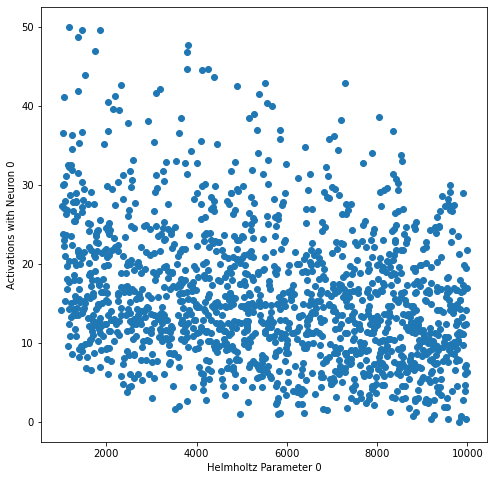

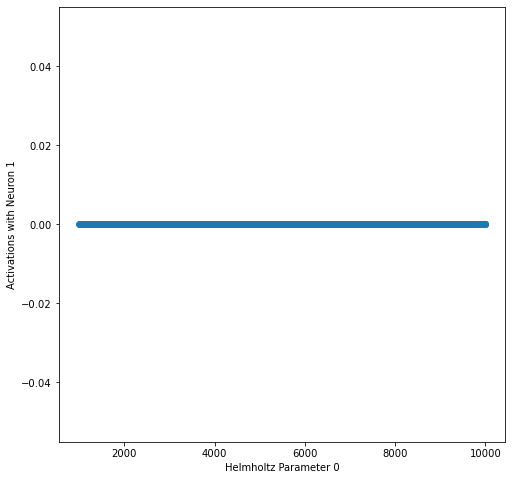

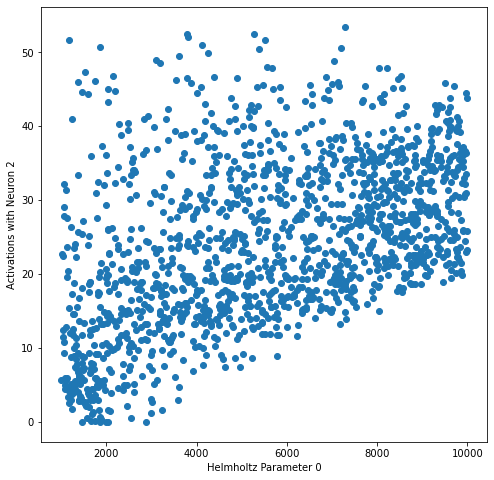

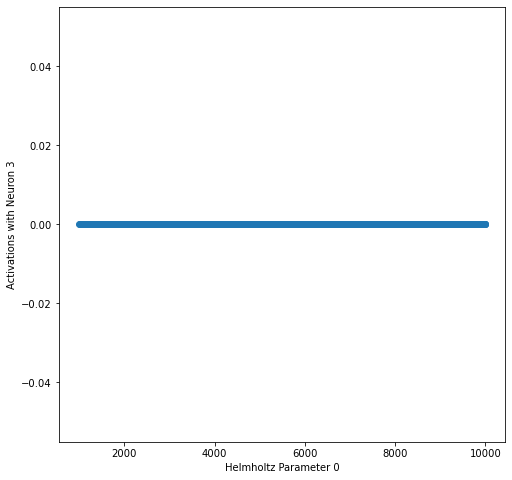

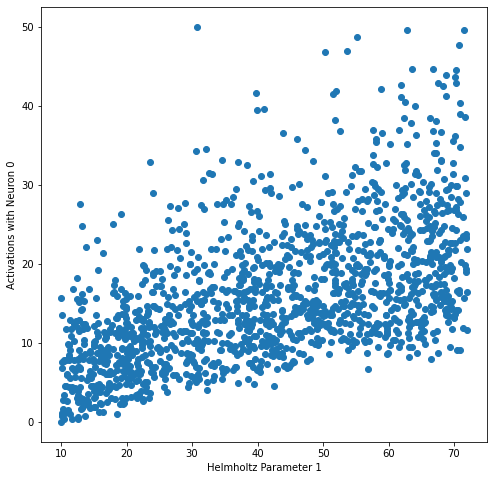

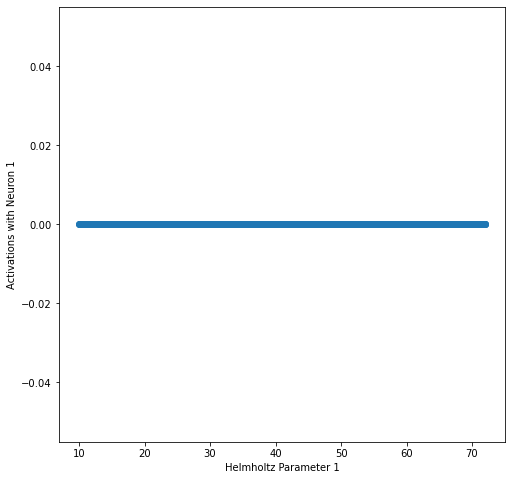

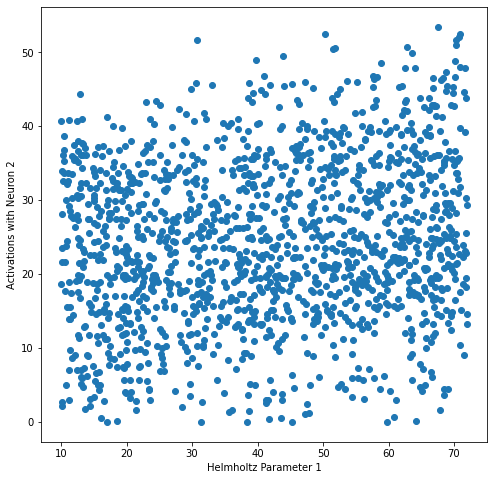

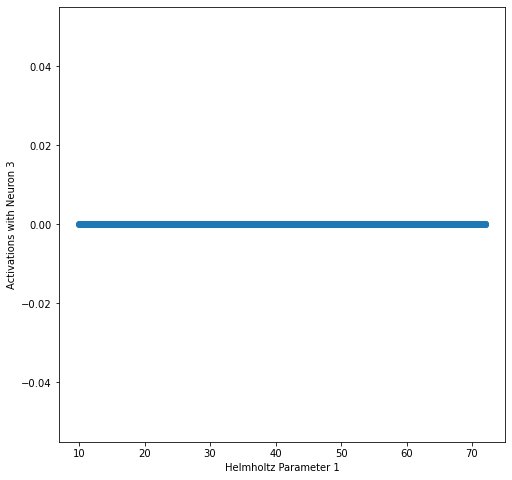

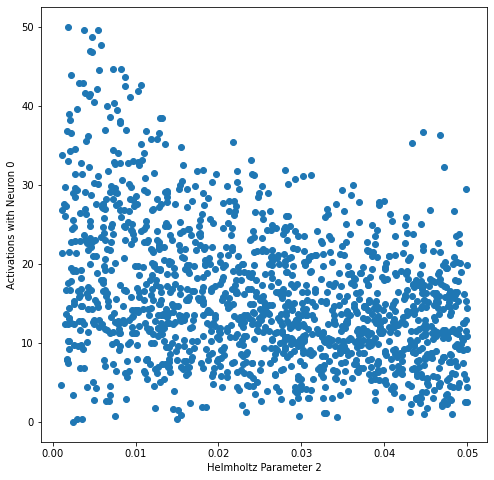

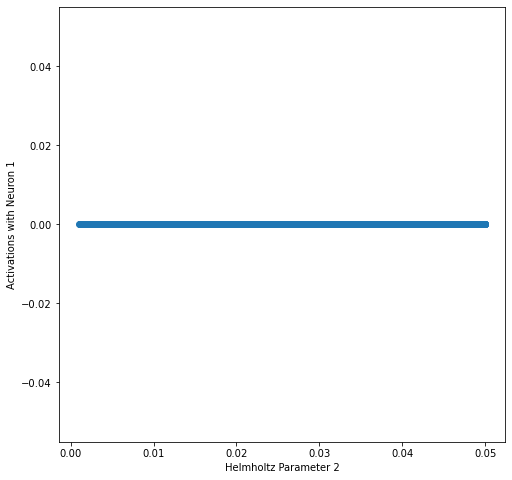

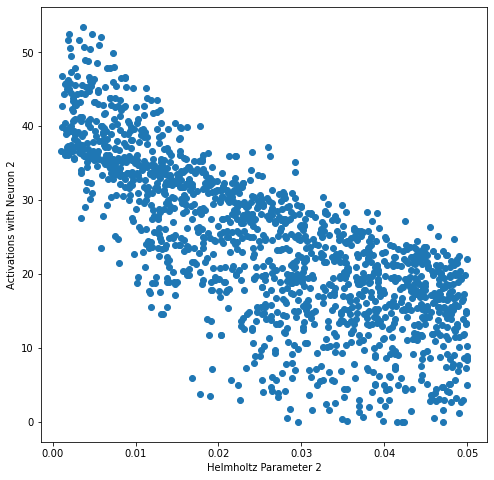

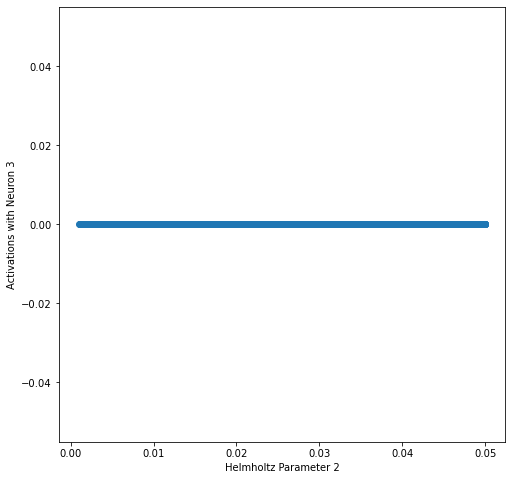

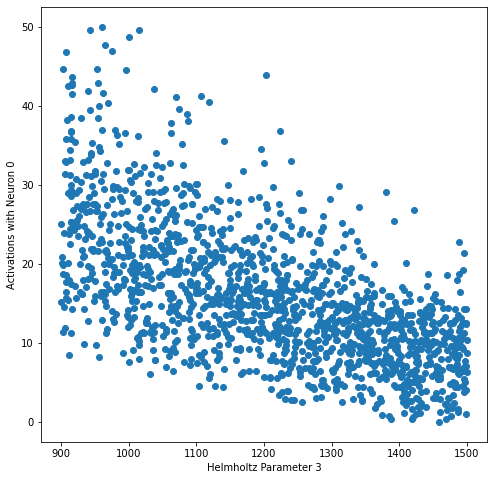

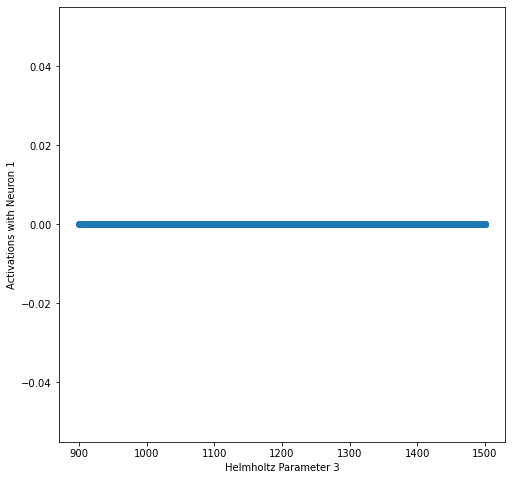

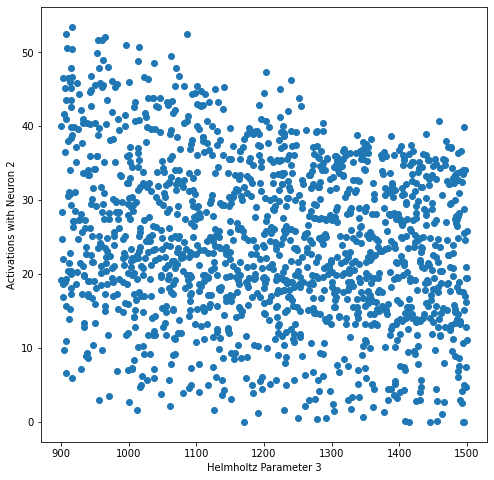

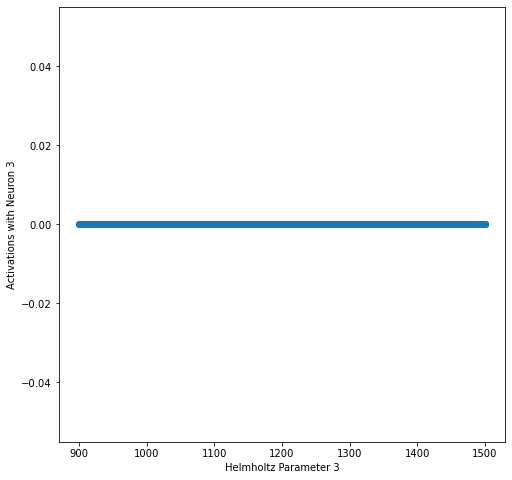

In [14]:
# Plot formula parameters against activations
plot_correlations(params, activs, model_name)

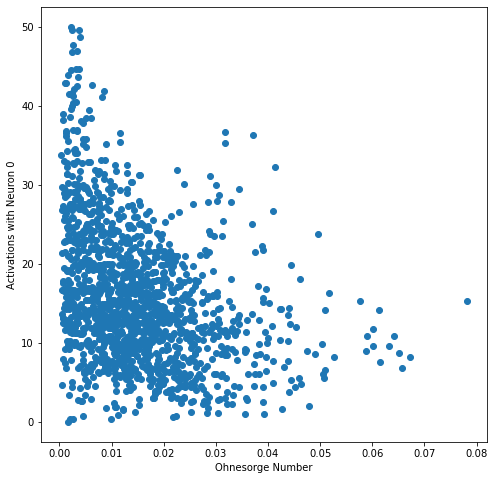

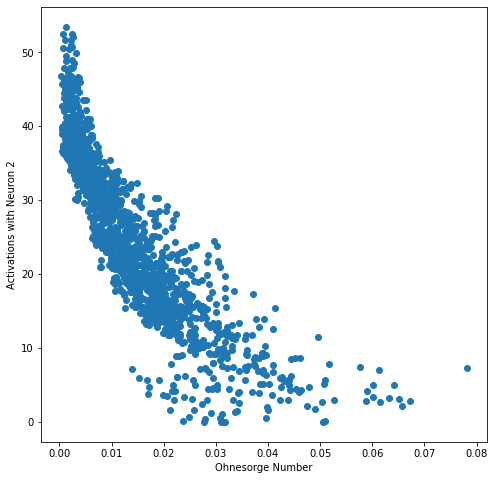

In [15]:
# Plot Ohnesorge numbers against activations
plot_ohnesorge(params, activs, model_name)

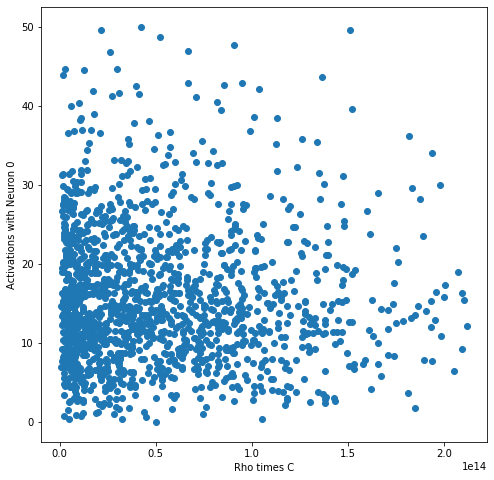

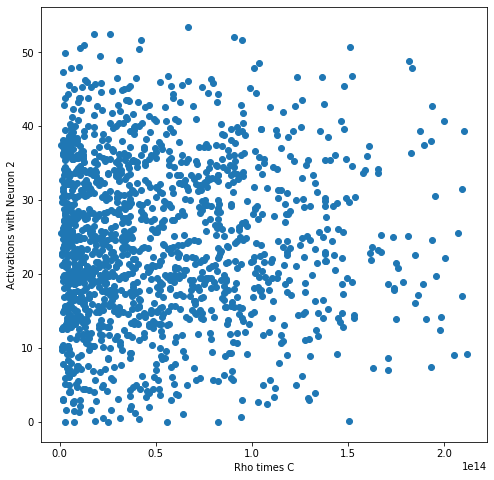

In [120]:
# Plot rho times c against activations
plot_rho_c(params, activs, model_name)

# Ridge Regression

To use, must first run the Formula Parameters-Activation Plotting cells.

In [29]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split

In [30]:
# Remove activations that are always 0
activs_del = np.delete(activs, 1, 1)
activs_del = np.delete(activs_del, 2, 1)
# activs_del = np.delete(activs_del, 1, 1)
print(activs_del.shape)

(1500, 2)


In [57]:
# Multi-Output Ridge Regression with X = parameters and y = activations

scaler = StandardScaler().fit(params)
params_normal = scaler.transform(params)

# params_normal = params_normal.T
# activs_t = activs_del.T

# params_slc = params_normal[0:5, :]
# print(params_slc)
# activs_slc = activs_del[0:5, :]
# print(activs_slc)

params_X_train, params_X_test, activs_y_train, activs_y_test = train_test_split(params_normal, activs_del, test_size=0.25, random_state=10)

ridge_reg = MultiOutputRegressor(KernelRidge(kernel='polynomial', degree=7, coef0=1)).fit(params_X_train, activs_y_train)
ridge_reg.score(params_X_test, activs_y_test)

0.9821103093396513

In [19]:
# Multi-Output Ridge Regression with X = activations and y = parameters

scaler = MinMaxScaler().fit(activs_del)
activs_normal = scaler.transform(activs_del)

activs_X_train, activs_X_test, params_y_train, params_y_test = train_test_split(activs_normal, params, test_size=0.25, random_state=10)

ridge_reg = MultiOutputRegressor(KernelRidge(kernel='polynomial', degree=4, coef0=1)).fit(activs_X_train, params_y_train)
ridge_reg.score(activs_X_test, params_y_test)

0.5204388951982059

In [20]:
# Single-Output Ridge Regression for each combination of one parameter and one activation.

for i, param in enumerate(params.T):
    for j, activ in enumerate(activs_del.T):
        param = np.reshape(param, (1500, 1))
        activ = np.reshape(activ, (1500, 1))
        scaler = MinMaxScaler().fit(param)
        param_normal = scaler.transform(param)
        
        param_X_train, param_X_test, activ_y_train, activ_y_test = train_test_split(param_normal, activ, test_size=0.25, random_state=10)

        ridge_reg = KernelRidge(kernel='polynomial', degree=1, coef0=1).fit(param_X_train, activ_y_train)
        score = ridge_reg.score(param_X_test, activ_y_test)
        print(f'parameter {i}, activation {j}: R2 Score = {score}')

parameter 0, activation 0: R2 Score = 0.08018328844939016
parameter 0, activation 1: R2 Score = 0.25479103826283733
parameter 1, activation 0: R2 Score = 0.37342071062792803
parameter 1, activation 1: R2 Score = 0.013226917253870596
parameter 2, activation 0: R2 Score = 0.10708389214338243
parameter 2, activation 1: R2 Score = 0.5867774893208266
parameter 3, activation 0: R2 Score = 0.3963243210917239
parameter 3, activation 1: R2 Score = 0.03045478834272486


# Testing

In [12]:
def test(model, n_features):
    # Decoupled into three lists due to issue with placing torch tensors into multidimensional lists
    batches = []
    recons = []
    test_losses = []
    criterion = nn.BCELoss()

    # Prepare model for evaluation
    model.eval()

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, batch in enumerate(test_loader, 0):
            # remove params, keep data
            batch = batch[0]
            # move data to device
            batch = batch.to(device)
            bottleneck, reconstructions = model(batch)
            # Reconstruction loss
            test_loss = criterion(reconstructions, batch)
            # Store samples, predictions, and loss for visualization purposes
            batches.append(batch)
            recons.append(reconstructions)
            test_losses.append(test_loss.item())
            print(f'Batch {i}: {test_loss.item()}')

    avg_test_loss = np.average(test_losses)
    print(f"Average Test Reconstruction Loss: {avg_test_loss}")
    
    return batches, recons, test_losses

In [13]:
# BASIC MODEL TEST
batches, recons, test_losses = test(basic_trained.model, n_features)

Batch 0: 0.010622023604810238
Batch 1: 0.006641016341745853
Batch 2: 0.008218773640692234
Batch 3: 0.00646587647497654
Batch 4: 0.006603226065635681
Batch 5: 0.007328255567699671
Batch 6: 0.00511541124433279
Batch 7: 0.00719464523717761
Batch 8: 0.0052178120240569115
Batch 9: 0.009407240897417068
Batch 10: 0.006843064911663532
Batch 11: 0.005628968123346567
Batch 12: 0.0071666305884718895
Batch 13: 0.006145533639937639
Batch 14: 0.006335104815661907
Batch 15: 0.006419111043214798
Batch 16: 0.005719826091080904
Batch 17: 0.005531244911253452
Batch 18: 0.007132391445338726
Batch 19: 0.00838631484657526
Batch 20: 0.006754396948963404
Batch 21: 0.008424021303653717
Batch 22: 0.010948991402983665
Batch 23: 0.005539849400520325
Batch 24: 0.006196320988237858
Batch 25: 0.008175981231033802
Batch 26: 0.00502089923247695
Batch 27: 0.006995979230850935
Batch 28: 0.003703894093632698
Batch 29: 0.006227264646440744
Batch 30: 0.0058709061704576015
Batch 31: 0.0068747783079743385
Batch 32: 0.0059709

In [55]:
# SPARSE MODEL TEST
batches, recons, test_losses = test(sparse_trained.model, n_features)

Batch 0: 0.009051457978785038
Batch 1: 0.006962968036532402
Batch 2: 0.008486664853990078
Batch 3: 0.006829945370554924
Batch 4: 0.006951460614800453
Batch 5: 0.010006973519921303
Batch 6: 0.004857387859374285
Batch 7: 0.007002027239650488
Batch 8: 0.005335994530469179
Batch 9: 0.009473899379372597
Batch 10: 0.007658135145902634
Batch 11: 0.006438864395022392
Batch 12: 0.008227875456213951
Batch 13: 0.0070784008130431175
Batch 14: 0.006576946005225182
Batch 15: 0.008005345240235329
Batch 16: 0.005998560693114996
Batch 17: 0.005109238438308239
Batch 18: 0.006268978118896484
Batch 19: 0.009302851743996143
Batch 20: 0.006902267690747976
Batch 21: 0.007767305243760347
Batch 22: 0.011868637055158615
Batch 23: 0.006220769137144089
Batch 24: 0.006589134223759174
Batch 25: 0.008141114376485348
Batch 26: 0.005145126022398472
Batch 27: 0.007765709422528744
Batch 28: 0.004028357099741697
Batch 29: 0.006486959755420685
Batch 30: 0.006531390827149153
Batch 31: 0.0063080089166760445
Batch 32: 0.0075

# Visualization

Jaccard Similarity (Both avg'd): 0.9911504424778761


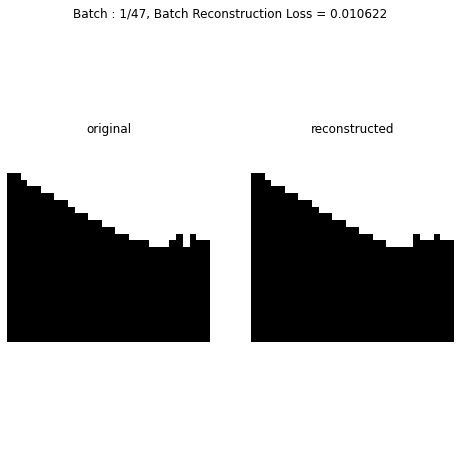

Jaccard Similarity (Both avg'd): 0.9801980198019802


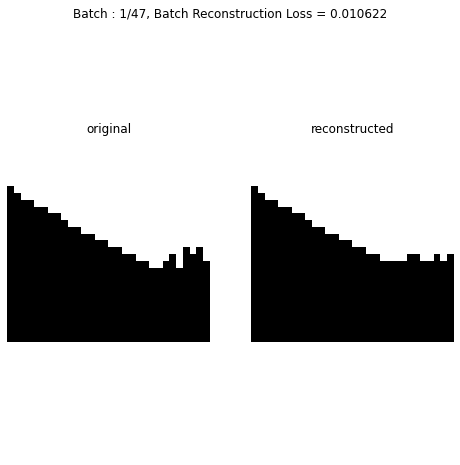

Jaccard Similarity (Both avg'd): 0.9933554817275747


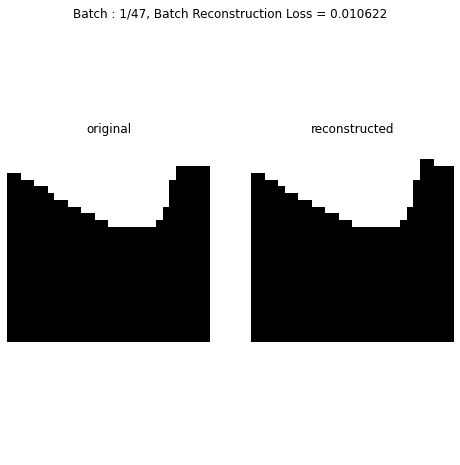

Jaccard Similarity (Both avg'd): 0.9955654101995566


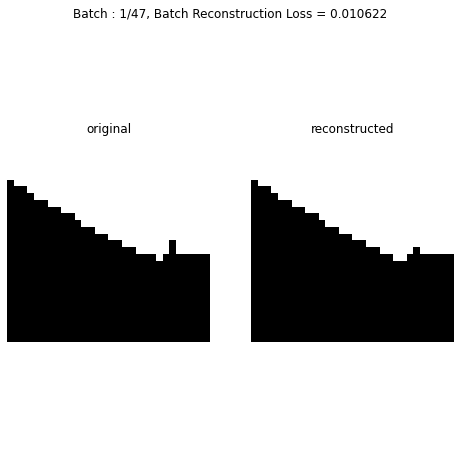

Jaccard Similarity (Both avg'd): 1.0


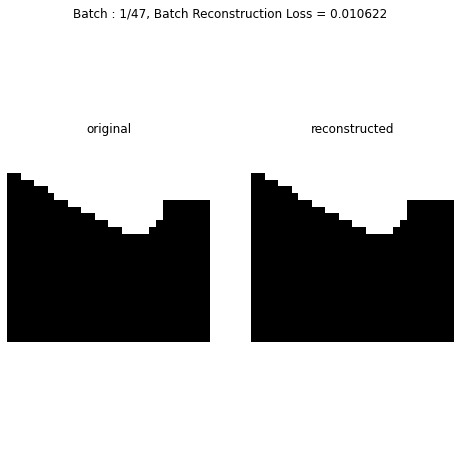

Jaccard Similarity (Both avg'd): 0.9955654101995566


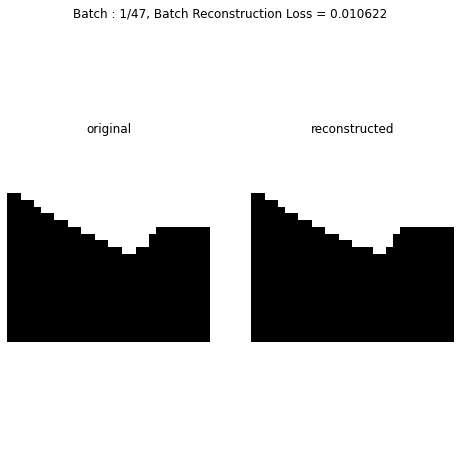

Jaccard Similarity (Both avg'd): 0.988950276243094


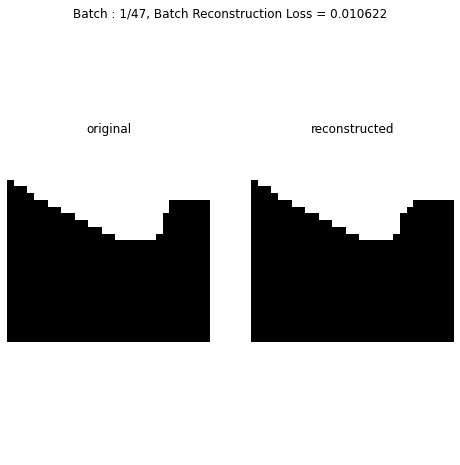

Jaccard Similarity (Both avg'd): 1.0


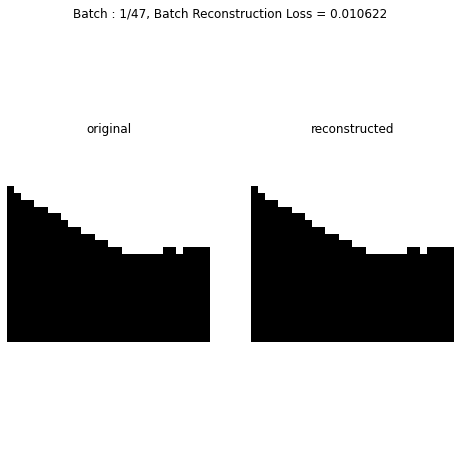

Jaccard Similarity (Both avg'd): 0.9867549668874173


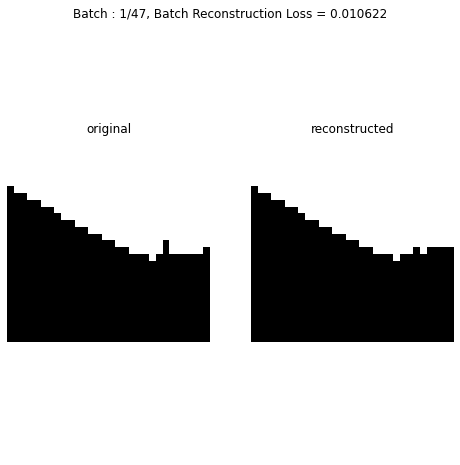

Jaccard Similarity (Both avg'd): 1.0


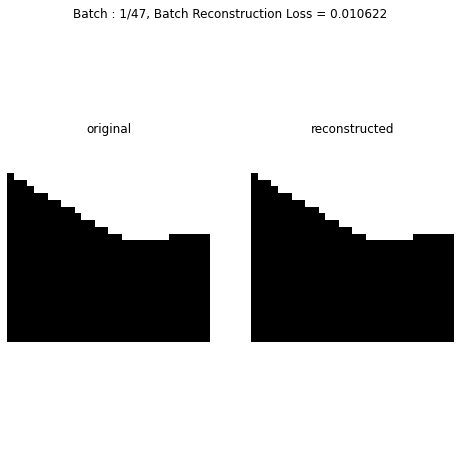

Jaccard Similarity (Both avg'd): 0.9933554817275747


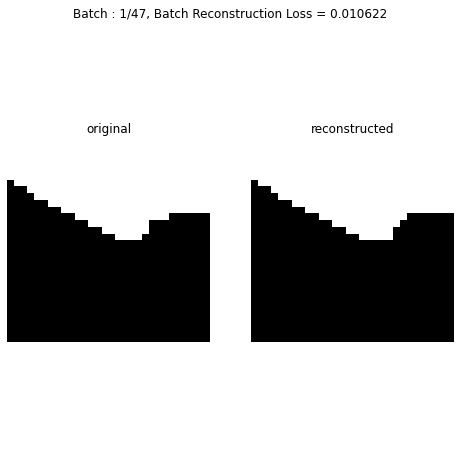

Jaccard Similarity (Both avg'd): 0.988950276243094


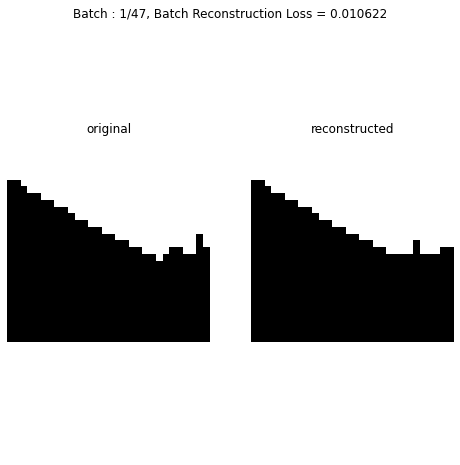

Jaccard Similarity (Both avg'd): 0.9955654101995566


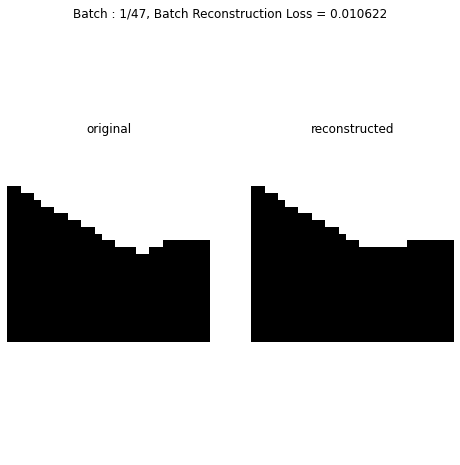

Jaccard Similarity (Both avg'd): 0.9977802441731409


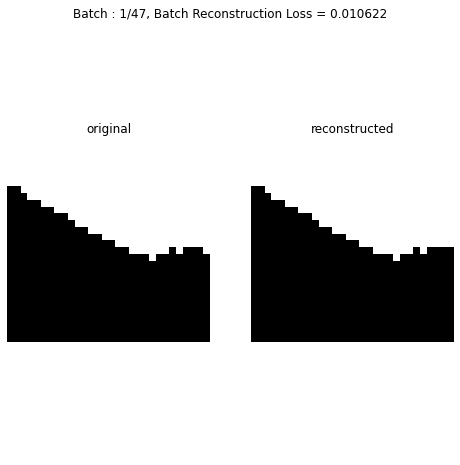

Jaccard Similarity (Both avg'd): 0.9977802441731409


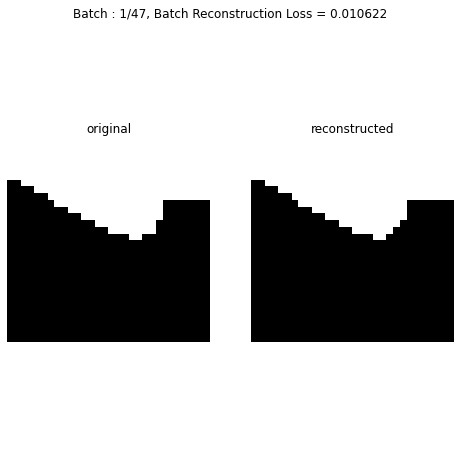

Jaccard Similarity (Both avg'd): 0.9977802441731409


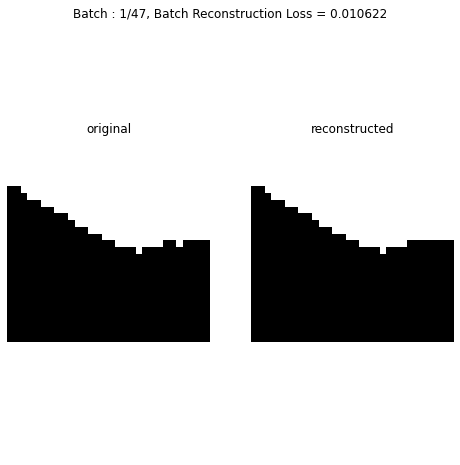

Jaccard Similarity (Both avg'd): 1.0


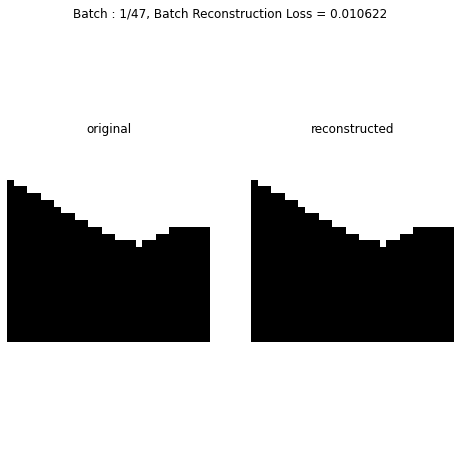

Jaccard Similarity (Both avg'd): 1.0


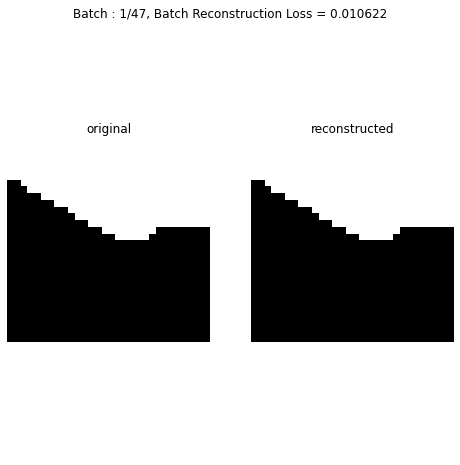

Jaccard Similarity (Both avg'd): 0.9672131147540983


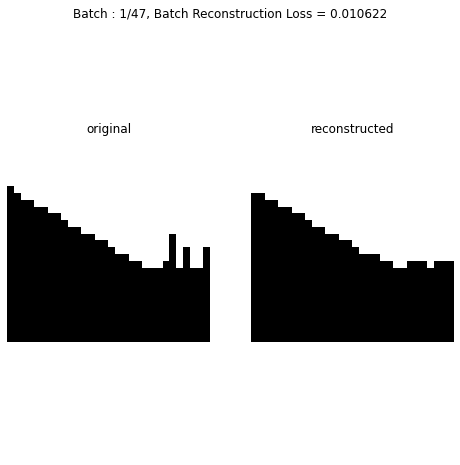

Jaccard Similarity (Both avg'd): 0.9977802441731409


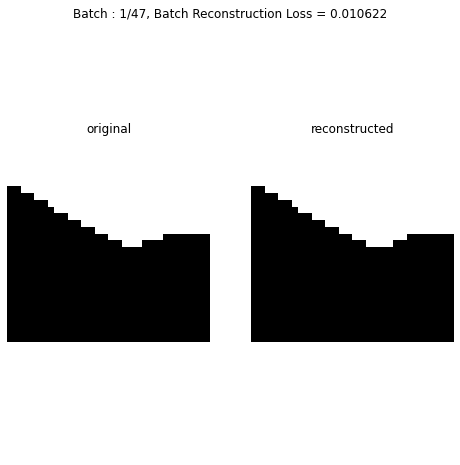

In [36]:
# Calculate Intersection over Union
def iou(cur_img, original, recon):
    path = r'data\iou'
    
    for i, x in enumerate(recon):
        for j, y in enumerate(x):
            if y.data < 0.5:
                recon[i,j] = 0.0
            else:
                recon[i,j] = 1.0
                
    original_flat  = original.flatten().numpy().astype(int)
    recon_flat = recon.flatten().numpy().astype(int)
    
    # Jaccard Scores of positive and negative classes
    score = jaccard_score(original_flat, recon_flat, average=None)
    # Average Jaccard Score between both classes
    score_micro = jaccard_score(original_flat, recon_flat, average='micro')
    return score, score_micro

    
# Plot original image alongside its reconstruction
def plot(cur_batch, tot_batches, original, recon, loss):
    fig = plt.figure(figsize=(8, 8))
    plt.title("Batch : {}/{}, Batch Reconstruction Loss = {:.6f}".format(cur_batch+1, tot_batches, loss))
    plt.axis('off')
    # display original
    fig.add_subplot(1, 2, 1)
    plt.imshow(original)
    plt.axis('off')
    plt.title("original")
    plt.gray()

    # display reconstruction
    fig.add_subplot(1, 2, 2)
    plt.imshow(recon)
    plt.axis('off')
    plt.title("reconstructed")
    plt.gray()
    plt.show()
    

# Main function for visualization
def visualize(n, batches, recons, test_losses, is_compare=False, is_iou=False):
    count = 0
    scores = []
    avg_iou = 0
    for i in range(n):
        loss = test_losses[i]
        batch = batches[i]
        reconstructions = recons[i]
        # Iterate through all examples in ith batch
        for j in range(len(batch)):
            # If n plots have been printed, exit
            if count >= n:
                return
            # Reshape original example for plotting back into 30x30
            # or keep as vector of components if using PCA.
            if is_pca:
                original = batch[j].reshape(1, n_features)
            else:
                original = batch[j].reshape(data.shape[1], data.shape[2])
            original = original.cpu()
            # Reshape reconstructed example for plotting
            # or keep as vector of components if using PCA.
            if is_pca:
                recon = reconstructions[j].reshape(1, n_features)
            else:
                recon = reconstructions[j].reshape(data.shape[1], data.shape[2])
            recon = recon.cpu()

            if is_iou:
                score, score_micro = iou(count, original, recon)
                scores.append(score_micro)
                # print(f'Jaccard Similarity (Pos. & Neg.): {score}')
                print(f"Jaccard Similarity (Both avg'd): {score_micro}")
                #print(score_micro[0])
            if is_compare:
                # print(original)
                plot(i, len(recons), original, recon, loss)


            count += 1
            
#     score = 0
#     print(scores)
#     for i in scores:
#         print(i)
#         score += i.data
#     score = score / len(scores)
#     print(score)
            
visualize(n=20, batches=batches, recons=recons, test_losses=test_losses, is_compare=True, is_iou=True)

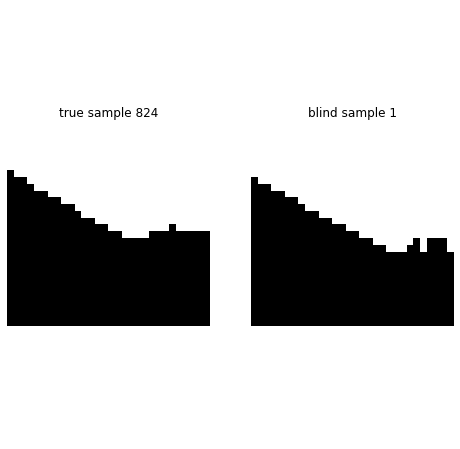

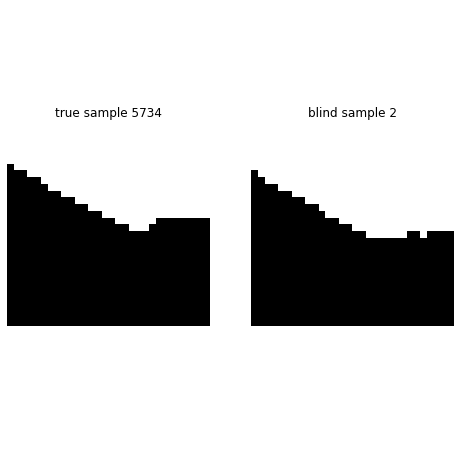

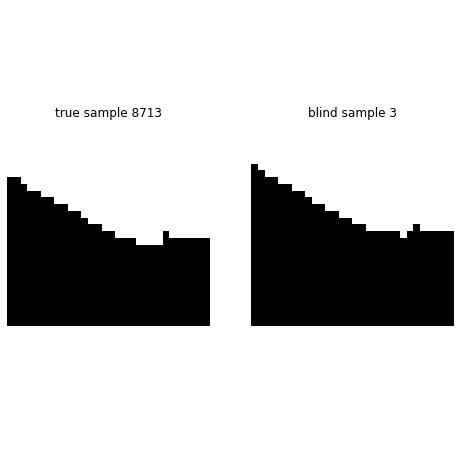

In [ ]:
true = np.ndarray(shape=(3,30,30))
blind = np.ndarray(shape=(3,30,30))


path = 'data/true_diagrams/sample824.dat'
sample = np.loadtxt(path, unpack = False)
true[0] = sample
path = 'data/true_diagrams/sample5734.dat'
sample = np.loadtxt(path, unpack = False)
true[1] = sample
path = 'data/true_diagrams/sample8713.dat'
sample = np.loadtxt(path, unpack = False)
true[2] = sample

path = 'data/true_diagrams/blind_sample1.dat'
sample = np.loadtxt(path, unpack = False)
blind[0] = sample
path = 'data/true_diagrams/blind_sample2.dat'
sample = np.loadtxt(path, unpack = False)
blind[1] = sample
path = 'data/true_diagrams/blind_sample3.dat'
sample = np.loadtxt(path, unpack = False)
blind[2] = sample

fig = plt.figure(figsize=(8, 8))
plt.axis('off')
fig.add_subplot(1, 2, 1)
plt.imshow(true[0])
plt.axis('off')
plt.title("true sample 824")
plt.gray()

fig.add_subplot(1, 2, 2)
plt.imshow(blind[0])
plt.axis('off')
plt.title("blind sample 1")
plt.gray()
path = 'data/true_diagrams/comparison824.png'
plt.savefig(path)
plt.show()



fig = plt.figure(figsize=(8, 8))
plt.axis('off')
fig.add_subplot(1, 2, 1)
plt.imshow(true[1])
plt.axis('off')
plt.title("true sample 5734")
plt.gray()

fig.add_subplot(1, 2, 2)
plt.imshow(blind[1])
plt.axis('off')
plt.title("blind sample 2")
plt.gray()
path = 'data/true_diagrams/comparison5734.png'
plt.savefig(path)
plt.show()


fig = plt.figure(figsize=(8, 8))
plt.axis('off')
# display original
fig.add_subplot(1, 2, 1)
plt.imshow(true[2])
plt.axis('off')
plt.title("true sample 8713")
plt.gray()

# display reconstruction
fig.add_subplot(1, 2, 2)
plt.imshow(blind[2])
plt.axis('off')
plt.title("blind sample 3")
plt.gray()
path = 'data/true_diagrams/comparison8713.png'
plt.savefig(path)
plt.show()